# Introduction

Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that will analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.

The goal is to develop a model with the highest possible accuracy, with a minimum accuracy of at least 75%.

This notebook will test three different ML models with varying hyperparameters to determine the best model to meet Megaline's requirements. 

In [29]:
# Import standard libraries
import os
import warnings
import joblib

# Import 3rd party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score # for sanity checks
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

# Scikit Optimize imports
from skopt import gp_minimize
from skopt.space import Categorical, Integer

In [30]:
# Import the data
try:
    # Local path
    data = pd.read_csv('users_behavior.csv')
except:
    # TripleTen path
    data = pd.read_csv('/datasets/users_behavior.csv')

# restet the index for good measure
data.reset_index(drop=True, inplace=True)

# Initial Inspection of Data

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [32]:
# Describe the data
print(data.describe())

# Get percent of is_ultra
print()
print(data['is_ultra'].value_counts(normalize=True))

             calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000     1.000000
max     244.000000  1632.060000   224.000000  49745.730000     1.000000

is_ultra
0    0.693528
1    0.306472
Name: proportion, dtype: float64


**Plan representation** there is a ~ 30 / 70 representation with the plans favoring the Smart plan, this may need to be accounted for in the training. I think I will use class weighting to address this.

There are no missing values in the dataset and all the columns are the correct types.  
There is significant spread in the features, but this is expected considering the variability in cell service usage.  
The zero values in the features should be left as is, because many users do not use one or several services at all and should be considered in the model.  

# Split Data into train, validate, and test sets

In [33]:
# Define features and target
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

# Define a constant for the random state
random_state = 12345

# Split the data into 60% train, 40% test/validate
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=random_state, stratify=target) # stratify to account for the imbalance in the target

# Split the test data into 50% test, 50% validate
features_validate, features_test, target_validate, target_test = train_test_split(features_test, target_test, test_size=0.5, random_state=random_state, stratify=target_test) # stratify to account for the imbalance in the target

# Check the shapes
print(f'Features Train: {features_train.shape}')
print(f'Target Train: {target_train.shape}, percent of is_ultra: {target_train.value_counts(normalize=True)[1]:.2f}.')
print(f'Features Validate: {features_validate.shape}')
print(f'Target Validate: {target_validate.shape}, percent of is_ultra: {target_validate.value_counts(normalize=True)[1]:.2f}')
print(f'Features Test: {features_test.shape}')
print(f'Target Test: {target_test.shape}, percent of is_ultra: {target_test.value_counts(normalize=True)[1]:.2f}')

Features Train: (1928, 4)
Target Train: (1928,), percent of is_ultra: 0.31.
Features Validate: (643, 4)
Target Validate: (643,), percent of is_ultra: 0.31
Features Test: (643, 4)
Target Test: (643,), percent of is_ultra: 0.31


The data set has been split into 60% training, 20% validate, 20% final test. Each subset has approximately the same is_ultra ratio to the full dataset.

In [34]:
model_test_scores = []

# Sanity Check

Against weighted random predictions

In [35]:
# Number of instances in the test set
n_test = len(target_test)

# Define np random seed
np.random.seed(random_state)

# Make the weighted random predictions
random_predictions = np.random.choice([0, 1], size=n_test, p=[0.7, 0.3]) # 70% chance of 0, 30% chance of 1

# Calculate the accuracy of the random predictions
random_accuracy = accuracy_score(target_test, random_predictions)
print(f'Random predictions score: {random_accuracy}')

Random predictions score: 0.5614307931570762


Against constant prediction of the majority class (Smart plan)

In [36]:
# pd series of len(target_test) with all 0s
baseline_predictions = pd.Series(np.zeros(n_test))

# Calculate the accuracy of the baseline predictions
baseline_accuracy = accuracy_score(target_test, baseline_predictions)
print(f'Baseline predictions score: {baseline_accuracy}')


Baseline predictions score: 0.6936236391912908


Using random predictions, we get an accuracy of 56%.  
Using a baseline prediction of always guessing 0, or the Smart plan, we get an accuracy of about 69%.  
Both of these values are below the stated business requirement for an accuracy of 75%, so 75% continues to be the threshold for what we will consider a successful model.

# Functions

In [37]:
def test_model(params, model_name, features_train=features_train, target_train=target_train, features_validate=features_validate, target_validate=target_validate, features_test=features_test, target_test=target_test, random_state=random_state):
    """
    Test a machine learning model on the test data and return the test score.

    Parameters:
    - params (dict): A dictionary of hyperparameters for the model.
    - model_name (class): The class name of the model to be tested.
    - features_train (DataFrame): The training features data.
    - target_train (Series): The training target data.
    - features_validate (DataFrame): The validation features data.
    - target_validate (Series): The validation target data.
    - features_test (DataFrame): The test features data.
    - target_test (Series): The test target data.
    - random_state (int): The random state for reproducibility.

    Returns:
    - dict: A dictionary containing the model name, test score, and parameters.
    """
    # Retrain the model with the best parameters using the training and validation data
    model = model_name(random_state=random_state, **params)
    model.fit(pd.concat([features_train, features_validate]), pd.concat([target_train, target_validate]))

    # Test the model on the test data
    test_score = model.score(features_test, target_test)
    print(f'{model_name.__name__} Test Score: {test_score}')
    
    # Get predictions for confusion matrix
    predictions = model.predict(features_test)
    
    # Get the confusion matrix
    cm = confusion_matrix(target_test, predictions)
    
    # Define labels for each quadrant
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    # Plot the confusion matrix with labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name.__name__} Confusion Matrix')
    plt.show()

    return {'model': model_name.__name__, 'score': test_score, 'parameters': params}


In [38]:
def validate_DecisionTreeClassifier_depth(features_train, target_train, features_validate, target_validate, random_state, range_start, range_end):
    """
    Validates the DecisionTreeClassifier model by varying the max_depth parameter within a given range.

    Parameters:
    - features_train (array-like): Training features.
    - target_train (array-like): Training target.
    - features_validate (array-like): Validation features.
    - target_validate (array-like): Validation target.
    - random_state (int): Random state for reproducibility.
    - range_start (int): Starting value of max_depth range.
    - range_end (int): Ending value of max_depth range.

    Returns:
    - best_score (float): Best score achieved by the model.
    - best_depth (int): Best max_depth value that achieved the best score.
    - results_df (DataFrame): DataFrame containing the scores for each max_depth value.
    """
    results = []
    for depth in range(range_start, range_end):
        model = DecisionTreeClassifier(max_depth=depth, random_state=random_state)
        model.fit(features_train, target_train)
        score = model.score(features_validate, target_validate)
        results.append({'depth': depth, 'score': score})

    results_df = pd.DataFrame(results)
    
    best_score = results_df['score'].max()
    best_depth = results_df.loc[results_df['score'].idxmax()]['depth']

    # Plot the results
    results_df.plot(x='depth', y='score', title='Decision Tree score by Depth')
    # Keep xticks in integer format
    plt.xticks(np.arange(range_start, range_end, 1))
      
    
    plt.show()
    
    print(f'\nDecisionTreeClassifier: Best Score: {best_score}, Best Depth: {best_depth}')

    return best_score, best_depth

In [39]:
def validate_DecisionTreeClassifier(features_train=features_train, target_train=target_train, features_validate=features_validate, target_validate=target_validate, random_state=random_state,
                                class_weight=[None,'balanced'], max_depth=list(range(1, 21))+[None], splitter=['best', 'random'],
                                criterion=['gini', 'entropy', 'log_loss'], min_samples_split=list(range(2, 18)),
                                min_samples_leaf=list(range(1, 18)), max_features=[None, 'sqrt', 'log2']):
    """
    Test different configurations of the DecisionTreeClassifier model and return the best score and parameters.
    
    Parameters:
    - features_train: The training features.
    - target_train: The training target.
    - features_validate: The validation features.
    - target_validate: The validation target.
    - random_state: The random state for reproducibility. Default is random_state.
    - class_weight: The class weight options. Default is [None, 'balanced']. Tests use of 'balanced' because the 'smart' plan is overrepresented in the data.
    - max_depth: The maximum depth of the tree. Default is a list from 1 to 20.
    - splitter: The strategy used to choose the split at each node. Default is ['best', 'random'].
    - criterion: The function to measure the quality of a split. Default is ['gini', 'entropy', 'log_loss].
    - min_samples_split: The minimum number of samples required to split an internal node. Default is a list from 2 to 18.
    - min_samples_leaf: The minimum number of samples required to be at a leaf node. Default is a list from 1 to 18.
    - max_features: The number of features to consider when looking for the best split. Default is [None, 'sqrt', 'log2'].
    - print_progress: Whether to print the progress of the model testing. Default is False.
    
    Returns:
    - best_score: The best score achieved by the model.
    - best_params: The parameters that resulted in the best score.
    - results_df: A DataFrame tracking the scores and parameters of each iteration.
    """
    
    results = []
    
    # Calculate total number of iterations
    total = len(class_weight) * len(max_depth) * len(splitter) * len(criterion) * len(min_samples_split) * len(min_samples_leaf) * len(max_features)

    # Wrap the loop in tqdm to show a progress bar
    with tqdm(total=total, desc='Testing DecisionTreeClassifier Parameters', unit='iterations') as pbar:
        for cw in class_weight:
            for md in max_depth:
                for s in splitter:
                    for c in criterion:
                        for mss in min_samples_split:
                            for msl in min_samples_leaf:
                                for mf in max_features:
                                    # Save params in a dict
                                    params = {'class_weight': cw, 'max_depth': md, 'splitter': s, 'criterion': c, 'min_samples_split': mss, 'min_samples_leaf': msl, 'max_features': mf}
                                    
                                    # Define, train, and score the model
                                    model = DecisionTreeClassifier(random_state=random_state, class_weight=cw, max_depth=md, splitter=s, criterion=c, min_samples_split=mss, min_samples_leaf=msl, max_features=mf)
                                    model.fit(features_train, target_train)
                                    score = model.score(features_validate, target_validate)
                                    
                                    # Save the results
                                    results.append({'score': score, 'params': params})
                                    
                                    # Update the progress bar
                                    pbar.update(1)
                                    
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Get the best score and params
    best_score = results_df['score'].max()
    best_params = results_df.loc[results_df['score'].idxmax()]['params']
        
    return best_score, best_params

In [40]:
def opti_validate_DecisionTreeClassifier(features_train=features_train, target_train=target_train, features_validate=features_validate, target_validate=target_validate, random_state=random_state,
                                    n_calls=100,
                                    class_weight_list=[None, 'balanced'],
                                    max_depth_range=(1, 21),
                                    include_none_in_max_depth=True,
                                    splitter_list=['best', 'random'],
                                    criterion_list=['gini', 'entropy', 'log_loss'],
                                    min_samples_split_range=(2, 18),
                                    min_samples_leaf_range=(1, 18),
                                    max_features_list=[None, 'sqrt', 'log2']):
    """
    Optimize DecisionTreeClassifier using Scikit-Optimize with a progress bar.

    Parameters:
    - features_train (DataFrame): The training features data.
    - target_train (Series): The training target data.
    - features_validate (DataFrame): The validation features data.
    - target_validate (Series): The validation target data.
    - random_state (int): The random state for reproducibility.
    - class_weight_list (list): List of class weight options.
    - max_depth_range (tuple): Range for max depth.
    - include_none_in_max_depth (bool): Whether to include None in max depth.
    - splitter_list (list): List of splitter options.
    - criterion_list (list): List of criteria options.
    - min_samples_split_range (tuple): Range for min samples split.
    - min_samples_leaf_range (tuple): Range for min samples leaf.
    - max_features_list (list): List of max features options.

    Returns:
    - best_score (float): The best validation score achieved.
    - best_params (dict): The best hyperparameters found during the optimization.
    """
    # Define the search space
    search_space = [
        Categorical(class_weight_list, name='class_weight'),
        Integer(max_depth_range[0], max_depth_range[1], name='max_depth') if not include_none_in_max_depth else Integer(max_depth_range[0], max_depth_range[1] + 1, name='max_depth'),
        Categorical(splitter_list, name='splitter'),
        Categorical(criterion_list, name='criterion'),
        Integer(min_samples_split_range[0], min_samples_split_range[1], name='min_samples_split'),
        Integer(min_samples_leaf_range[0], min_samples_leaf_range[1], name='min_samples_leaf'),
        Categorical(max_features_list, name='max_features')
    ]

    # Initialize the progress bar
    with tqdm(total=n_calls, desc='Optimizing DecisionTreeClassifier', unit='iteration') as pbar:
        def objective(params):
            class_weight, max_depth, splitter, criterion, min_samples_split, min_samples_leaf, max_features = params

            # Handle None for max_depth
            if include_none_in_max_depth and max_depth == max_depth_range[1] + 1:
                max_depth = None

            model = DecisionTreeClassifier(
                random_state=random_state,
                class_weight=class_weight,
                max_depth=max_depth,
                splitter=splitter,
                criterion=criterion,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features
            )

            # Train the model
            model.fit(features_train, target_train)

            # Evaluate the model
            score = model.score(features_validate, target_validate)

            # Update progress bar
            pbar.update(1)

            return -score

        # Perform the optimization
        result = gp_minimize(objective, search_space, n_calls=n_calls, random_state=random_state)

        # Close the progress bar
        pbar.close()

        # Extract the best parameters and score
        best_params = result.x
        best_score = -result.fun

        # Map the best parameters back to their names
        best_params_dict = {
            'class_weight': best_params[0],
            'max_depth': None if include_none_in_max_depth and best_params[1] == max_depth_range[1] + 1 else best_params[1],
            'splitter': best_params[2],
            'criterion': best_params[3],
            'min_samples_split': best_params[4],
            'min_samples_leaf': best_params[5],
            'max_features': best_params[6]
        }

        return best_score, best_params_dict

In [41]:
def opti_validate_RandomForrest(features_train=features_train, target_train=target_train, features_validate=features_validate, target_validate=target_validate,
                           n_calls=100,
                           n_estimators_range=(1, 100), criterion_list=['gini', 'entropy', 'log_loss'], max_depth_range=(1, 20), include_none_in_max_depth=True,
                           min_samples_split_range=(2, 10), min_samples_leaf_range=(1, 10), max_features_list=[None, 'sqrt', 'log2'], class_weight_list=[None, 'balanced']):
    """
    Optimize RandomForestClassifier using Scikit-Optimize with a progress bar.

    Parameters:
    - features_train (DataFrame): The training features data.
    - target_train (Series): The training target data.
    - features_validate (DataFrame): The validation features data.
    - target_validate (Series): The validation target data.
    - features_test (DataFrame): The test features data.
    - target_test (Series): The test target data.
    - random_state (int): The random state for reproducibility.
    - n_calls (int): The number of function evaluations.
    - n_estimators_range (tuple): Range for n_estimators.
    - criterion_list (list): List of criteria.
    - max_depth_range (tuple): Range for max_depth.
    - include_none_in_max_depth (bool): Whether to include None in max_depth.
    - min_samples_split_range (tuple): Range for min_samples_split.
    - min_samples_leaf_range (tuple): Range for min_samples_leaf.
    - max_features_list (list): List of max_features options.
    - class_weight_list (list): List of class_weight options.

    Returns:
    - best_score (float): The best validation score achieved.
    - best_params (dict): The best hyperparameters found during the optimization.
    """
    # Define the search space
    search_space = [
        Integer(n_estimators_range[0], n_estimators_range[1], name='n_estimators'),
        Categorical(criterion_list, name='criterion'),
        Integer(max_depth_range[0], max_depth_range[1] + 1, name='max_depth') if include_none_in_max_depth else Integer(max_depth_range[0], max_depth_range[1], name='max_depth'),
        Integer(min_samples_split_range[0], min_samples_split_range[1], name='min_samples_split'),
        Integer(min_samples_leaf_range[0], min_samples_leaf_range[1], name='min_samples_leaf'),
        Categorical(max_features_list, name='max_features'),
        Categorical(class_weight_list, name='class_weight')
    ]

    # Initialize the progress bar
    with tqdm(total=n_calls, desc='Optimizing RandomForest', unit='iteration') as pbar:
        def objective(params):
            n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, max_features, class_weight = params

            # Handle None for max_depth
            if include_none_in_max_depth and max_depth == max_depth_range[1] + 1:
                max_depth = None

            model = RandomForestClassifier(
                n_estimators=n_estimators,
                criterion=criterion,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                class_weight=class_weight,
                random_state=random_state
            )

            # Train the model
            model.fit(features_train, target_train)

            # Evaluate the model
            score = model.score(features_validate, target_validate)

            # Update progress bar
            pbar.update(1)

            return -score

        # Perform the optimization
        result = gp_minimize(objective, search_space, n_calls=n_calls, random_state=random_state)

        # Close the progress bar
        pbar.close()

        # Extract the best parameters and score
        best_params = result.x
        best_score = -result.fun

        # Map the best parameters back to their names
        best_params_dict = {
            'n_estimators': best_params[0],
            'criterion': best_params[1],
            'max_depth': None if include_none_in_max_depth and best_params[2] == max_depth_range[1] + 1 else best_params[2],
            'min_samples_split': best_params[3],
            'min_samples_leaf': best_params[4],
            'max_features': best_params[5],
            'class_weight': best_params[6]
        }

        return best_score, best_params_dict


In [42]:
def validate_LogisticRegression(features_train=features_train, target_train=target_train, features_validate=features_validate, target_validate=target_validate, random_state=random_state,
                                solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                duals = [True, False],
                                penalties = ['l1', 'l2', 'elasticnet', None]):
    """
    Validates the Logistic Regression model with different parameter combinations.

    Parameters:
    - features_train: Training features data.
    - target_train: Training target data.
    - features_validate: Validation features data.
    - target_validate: Validation target data.
    - random_state: Random state for reproducibility.
    - solvers: List of solvers to test.
    - duals: List of dual values to test.
    - penalties: List of penalties to test.

    Returns:
    - best_score: Best score achieved by the model.
    - best_params: Best parameters combination that achieved the best score.
    """

    # Ignore ConvergenceWarning
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # Ignore LineSearchWarning
    warnings.filterwarnings("ignore", message="^The line search algorithm did not converge")
    warnings.filterwarnings("ignore", message="^Line Search failed")
    
                                    
    results = []

    # Initialize the progress bar
    with tqdm(total=len(solvers) * len(duals) * len(penalties), desc='Testing LogisticRegression Parameters', unit='iterations') as pbar:
        for solver in solvers:
            for dual in duals:
                for penalty in penalties:
                    # Save params in a dict
                    params = {'solver': solver, 'dual': dual, 'penalty': penalty}
                    
                    # Define, train, and score the model
                    model = LogisticRegression(random_state=random_state, solver=solver, dual=dual, penalty=penalty, max_iter=1000000)
                    try: # try/except to handle invalid param combinations
                        model.fit(features_train, target_train)
                        score = model.score(features_validate, target_validate)
                        results.append({'score': score, 'params': params})
                        # Update the progress bar
                        pbar.update(1)
                    except:
                        pbar.update(1)
                        continue

                    
        # Close the progress bar
        pbar.close()

        # Convert the results to a DataFrame
        results_df = pd.DataFrame(results)

        # Get the best score and params
        best_score = results_df['score'].max()
        best_params = results_df.loc[results_df['score'].idxmax()]['params']
        
        return best_score, best_params

# Decision Tree Classifier

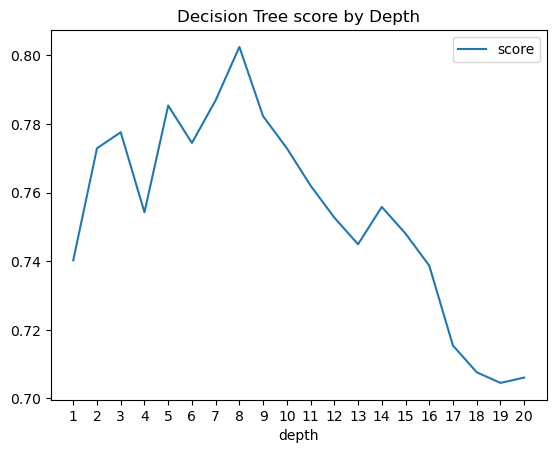


DecisionTreeClassifier: Best Score: 0.80248833592535, Best Depth: 8.0


(0.80248833592535, 8.0)

In [43]:
validate_DecisionTreeClassifier_depth(features_train, target_train, features_validate, target_validate, random_state, 1, 21)

A fairly accurate model (80%) is achieved with all the default values and a max_depth of 8.  

Next we will call a function to iterate over a larger set of parameters for the DecisionTreeClassifier that uses gp_minimize to optimize the search_space.

In [44]:
# best_score, best_params = opti_validate_DecisionTreeClassifier()
# print("Best Score:", best_score)
# print("Best Parameters:", best_params)

The score has actually gone down. It seems gp_minimize was not able to find the best parameters. Lets take a grid approach to testing the parameters instead and test all possible combinations.

In [45]:
# score, params = validate_DecisionTreeClassifier()
# print("Best Score:", score)
# print("Best Parameters:", params)

A slightly better model is found (improved by about 1.5%). We will now test the model with these parameters to compare to other models.

In [46]:
# Save the best parameters as code for easy reference (Avoids having to run the optimization again)
Score = 0.8165
params = {'class_weight': None, 'max_depth': 10, 'splitter': 'random', 'criterion': 'gini', 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': None}

DecisionTreeClassifier Test Score: 0.80248833592535


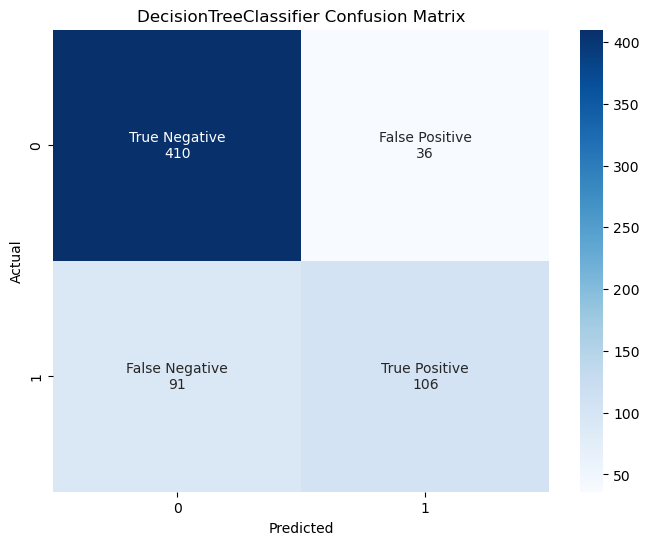

In [47]:
# Test the model with the best parameters on the test data
model_test_scores.append(test_model(params, DecisionTreeClassifier))

We do see some over fitting as the model performs about 1.4% better on the validation dataset than it does on the test set. The model also tends to error on the side of predicting the Smart plan (Likely because the Smart plan is over represented in the data - but using weight_class='balanced' was tested in the grid search and did not result in a better overall accuracy).  

This model exceeds the performance requirements to be considered a successful model, but lets test some other algorithms to see if we can get better results. 

# Random Forrest Classifier

For the sake of resources management we will call a function that uses gp_minimize from scikit optimize - same as with the DecisionTreeClassifier, but more necessary now that we are using RandomForrestClassifier.

In [48]:
# score, params = opti_validate_RandomForrest()
# print("Best Score:", score)
# print("Best Parameters:", params)

A significantly better performing model has been uncovered. Let's now test the model with the test dataset.

In [49]:
# Save the best parameters as code for easy reference (Avoids having to run the optimization again)
score = .8305
params = {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None, 'class_weight': None}

RandomForestClassifier Test Score: 0.8258164852255054


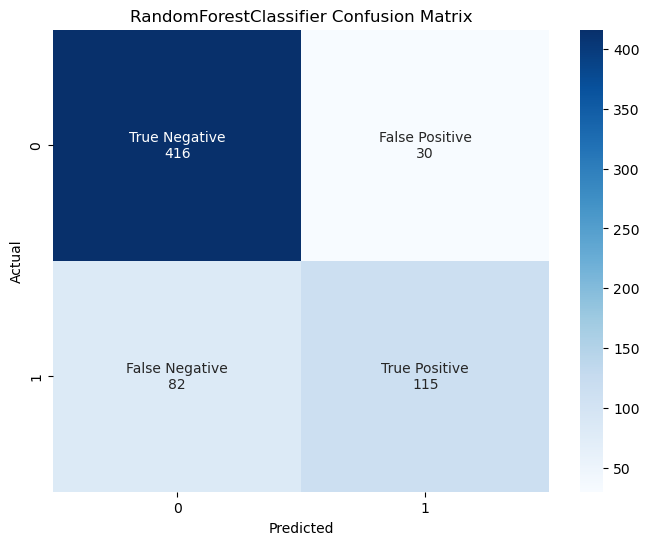

In [50]:
# Test the model with the best parameters on the test data
model_test_scores.append(test_model(params, RandomForestClassifier))

Not only does this model have a better overall accuracy score, it also improves its accuracy in all grids (less false predictions in both categories) compared to the DecisionTreeClassifier model.  
Additionally, the model shows less significant over fitting, with a difference of only ~ .05% between the validation and test sets. Much like the DecisionTreeClassifier, this model does tend to error on the side of predicting the Smart plan, but with fewer instances of that error.  

This model exceeds the requirements and performs better than the DecisionTreeClassifier. Lets move on to testing the LogisticRegressionClassifier.

# Logistic Regression Classifier

We'll start by using all the default arguements for LogisitcRegressionClassifier (solver='linlinear' instead of 'lbfgs') to get a general sense of the models performance, then we will attempt to refine from there.

In [51]:
# Train the Linear Regression model with basic parameters
model = LogisticRegression(random_state=random_state, solver='liblinear')

# Fit the model
model.fit(features_train, target_train)

# Get the score
score = model.score(features_validate, target_validate)

# Print the score
print(f'Logistic Regression Score: {score}')

Logistic Regression Score: 0.71850699844479


By a large margin, this is the lowest scoring model yet. Using a grid search approach, we will see if we can improve the model’s accuracy. The model will need to improve dramatically to compete with either of the previous models.

In [52]:
# # Validate the Regression model
# score, params = validate_LogisticRegression()
# print("Validation Score:", score)
# print("Best Parameters:", params)

The model improved some, but not nearly enough to match the accuracy of the previous two models. We'll test it with the test dataset to just to get an idea of its performance on unseen data.

LogisticRegression Test Score: 0.7480559875583204


/Volumes/T7/Coding_Files/TripleTen Data Science/Sprint 7/Project/.conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Volumes/T7/Coding_Files/TripleTen Data Science/Sprint 7/Project/.conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:43: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


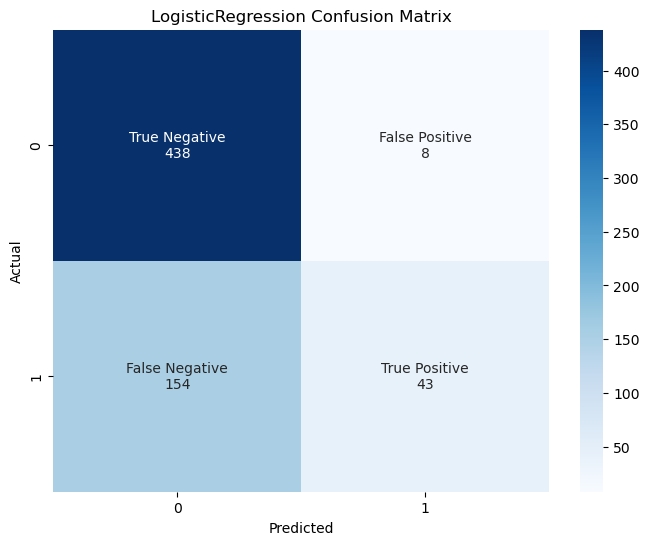

In [53]:
# Save the best parameters as code for easy reference (Avoids having to run the optimization again)
score = .7387
params = {'solver': 'newton-cg', 'dual': False, 'penalty': 'l2'}

# Test the model on the test data even though it's not the best, just to see how it performs in terms of overfitting
model_test_scores.append(test_model(params, LogisticRegression))

Interestingly, the model performed better on the unseen data set. However, we can see that this model tends to falsely predict the smart plan far more often than the previous two models.

# Comparing Test Scores

In [54]:
print(f"{model_test_scores[0]['model']} Test Score: {model_test_scores[0]['score']*100:.2f}%")
print(f"{model_test_scores[1]['model']} Test Score: {model_test_scores[1]['score']*100:.2f}%")
print(f"{model_test_scores[2]['model']} Test Score: {model_test_scores[2]['score']*100:.2f}%")

DecisionTreeClassifier Test Score: 80.25%
RandomForestClassifier Test Score: 82.58%
LogisticRegression Test Score: 74.81%


In [55]:
print(f'{model_test_scores[1]["model"]} parameters: {model_test_scores[1]["parameters"]}')

RandomForestClassifier parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None, 'class_weight': None}


# Conclusion

The best performing model has been determined to be the RandomForrestClassifier with a accuracy score of 82.58%.  

Parameters for the model:  
{'n_estimators': 100,  
'criterion': 'gini',  
'max_depth': 12,  
'min_samples_split': 10,  
'min_samples_leaf': 10,  
'max_features': None,  
'class_weight': None}

In [56]:
# Train the best model on the entire dataset
model = RandomForestClassifier(random_state=random_state, **model_test_scores[1]['parameters'])
model.fit(features, target)

# Save the model
joblib.dump(model, 'BestModel.joblib')

['BestModel.joblib']